<a href="https://colab.research.google.com/github/7201krap/PYTORCH_project/blob/main/selectivity_my_adadelta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torchvision import transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np

In [2]:
torch.manual_seed(1234)
np.random.seed(1234)

In [ ]:
class Adagrad:
    def __init__(self, model_params, lr=1e-2, init_acc_sqr_grad=0, eps=1e-10):
        self.model_params = list(model_params)
        self.lr = lr
        self.acc_sqr_grads = [torch.full_like(p, init_acc_sqr_grad) for p in self.model_params]
        self.eps = eps

    def zero_grad(self):
        for param in self.model_params:
            param.grad = None

    @torch.no_grad()
    def step(self):
        for param, acc_sqr_grad in zip(self.model_params, self.acc_sqr_grads):
            acc_sqr_grad.add_(param.grad * param.grad)
            std = acc_sqr_grad.sqrt().add(self.eps)
            param.sub_((self.lr / std) * param.grad)

In [3]:
class my_Adadelta:
    def __init__(self, model_params, lr=1.0, rho=0.9, eps=1e-6):
        self.model_params = list(model_params)
        self.lr = lr
        self.rho = rho
        self.eps = eps
        self.avg_sqr_grads = [torch.zeros_like(p) for p in self.model_params]
        self.avg_sqr_deltas = [torch.zeros_like(p) for p in self.model_params] 

    def zero_grad(self):
        for param in self.model_params:
            param.grad = None

    @torch.no_grad()
    def step(self):
        for param, avg_sqr_grad, avg_sqr_delta in zip(self.model_params, \
                                                      self.avg_sqr_grads, \
                                                      self.avg_sqr_deltas):
            avg_sqr_grad.mul_(self.rho).add_(param.grad * param.grad * (1 - self.rho))
            std = avg_sqr_grad.add(self.eps).sqrt()
            delta = avg_sqr_delta.add(self.eps).sqrt().div(std).mul(param.grad)
            param.sub_(self.lr * delta)
            avg_sqr_delta.mul_(self.rho).add_(delta * delta * (1 - self.rho))


In [4]:
mnist_trainset = datasets.MNIST(root='./data', train=True, 
                                download=True, 
                                transform=transforms.Compose([transforms.ToTensor()]))

mnist_testset  = datasets.MNIST(root='./data', 
                                train=False, 
                                download=True, 
                                transform=transforms.Compose([transforms.ToTensor()]))

train_dataloader = torch.utils.data.DataLoader(mnist_trainset, 
                                               batch_size=50, 
                                               shuffle=True)

test_dataloader  = torch.utils.data.DataLoader(mnist_testset, 
                                               batch_size=50, 
                                               shuffle=False)

print("Training dataset size: ", len(mnist_trainset))
print("Testing dataset size: ",  len(mnist_testset))

Training dataset size:  60000
Testing dataset size:  10000


In [5]:
# Define the model 
class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.linear_1 = torch.nn.Linear(784, 256)
        self.linear_2 = torch.nn.Linear(256, 10)
        self.sigmoid  = torch.nn.Sigmoid()

    def forward(self, x):
        x = x.reshape(x.size(0), -1)
        x = self.linear_1(x)
        x = self.sigmoid(x)
        pred = self.linear_2(x)

        return pred

In [6]:
def get_activation(model):    
    def hook(module, input, output):
        model.layer_activations = output
    return hook

In [7]:
# adadelta
model_adadelta = Model()
model_adadelta.sigmoid.register_forward_hook(get_activation(model_adadelta))
optimizer_adadelta = torch.optim.Adadelta(model_adadelta.parameters(), lr=1)

# my_adadelta
model_my_adadelta = Model()
model_my_adadelta.sigmoid.register_forward_hook(get_activation(model_my_adadelta))
optimizer_my_adadelta = my_Adadelta(model_my_adadelta.parameters(), lr=1)


In [8]:
no_epochs = 50
def selectivity_trainer(optimizer, model):

    hidden_layer_each_neuron = [{0:[], 1:[], 2:[], 3:[], 4:[], 5:[], 6:[], 7:[], 8:[], 9:[]} for x in range(256)]
    hidden_layer_each_neuron = np.array(hidden_layer_each_neuron)

    criterion = torch.nn.CrossEntropyLoss()
    train_loss = list()
    test_loss  = list()
    test_acc   = list()

    best_test_loss = 1

    for epoch in range(no_epochs):
        total_train_loss = 0
        total_test_loss = 0

        # training
        # set up training mode 
        model.train()

        for itr, (images, label) in enumerate(train_dataloader):

            optimizer.zero_grad()

            pred = model(images)

            loss = criterion(pred, label)
            total_train_loss += loss.item()

            loss.backward()
            optimizer.step()

            # Print/Append activation of the hidden layer 
            # print(model.layer_activations.shape)
            # model.layer_activations

        total_train_loss = total_train_loss / (itr + 1)
        train_loss.append(total_train_loss)

        # testing 
        # change to evaluation mode 
        model.eval()
        total = 0
        for itr, (images, labels) in enumerate(test_dataloader):

            pred = model(images)

            loss = criterion(pred, labels)
            total_test_loss += loss.item()

            # we now need softmax because we are testing.
            pred = torch.nn.functional.softmax(pred, dim=1)
            for i, p in enumerate(pred):
                if labels[i] == torch.max(p.data, 0)[1]:
                    total = total + 1

            # print("1:", labels.shape)   # 50 
            # print("2:", model.layer_activations.shape)  # 50, 256 

            # print(labels[0].shape) # 1
            # print(model.layer_activations[0].shape) # 256 

            # find selectivity at the final epoch 
            if epoch == no_epochs - 1: # last epoch 
                for activation, label in zip(model.layer_activations, labels):
                    # shape of activation and label: 256 and 1 
                    
                    # get the actual value of item. This is because label is now Tensor 
                    label = label.item()

                    # this is not part of gradient calculcation 
                    with torch.no_grad():
                        activation = activation.numpy()

                    # for each image/label, append activation value of neuron 
                    for i in range(256):    # number of neurons in hidden layer 
                        hidden_layer_each_neuron[i][label].append(activation[i])


        # caculate accuracy 
        accuracy = total / len(mnist_testset)

        # append accuracy here
        test_acc.append(accuracy)

        # append test loss here 
        total_test_loss = total_test_loss / (itr + 1)
        test_loss.append(total_test_loss)

        print('\nEpoch: {}/{}, Train Loss: {:.8f}, Test Loss: {:.8f}, Test Accuracy: {:.8f}'.format(epoch + 1, no_epochs, total_train_loss, total_test_loss, accuracy))

        if total_test_loss < best_test_loss:
            best_test_loss = total_test_loss
            print("Saving the model state dictionary for Epoch: {} with Test loss: {:.8f}".format(epoch + 1, total_test_loss))
            torch.save(model.state_dict(), "model.dth")

    # I will now try to find the average of each class for each neuron.
    # check out the next cell 
    avg_activations = [dict() for x in range(256)]
    for i, neuron in enumerate(hidden_layer_each_neuron):
        for k, v in neuron.items():
            # v is the list of activations for hidden layer's neuron k 
            avg_activations[i][k] = sum(v) / float(len(v))

    # generate 256 lists to get only values in avg_activations
    only_activation_vals = [list() for x in range(256)]

    # selectivity_list contains all of the selectivity of each neuron 
    selectivity_list = list()

    # get only values from avg_activations
    for i, avg_activation in enumerate(avg_activations):
        for value in avg_activation.values():
            only_activation_vals[i].append(value)


    for activation_val in only_activation_vals:
        # find u_max 
        u_max = np.max(activation_val)

        # find u_minus_max 
        u_minus_max = (np.sum(activation_val) - u_max) / 9

        # find selectivity 
        selectivity = (u_max - u_minus_max) / (u_max + u_minus_max)

        # append selectivity value to selectivity_list
        selectivity_list.append(selectivity)

    return test_acc, selectivity_list

In [9]:
print("\n===== Entering Adadelta optimizer =====\n")
adadelta_test_acc, adadelta_selectivity_list = selectivity_trainer(optimizer=optimizer_adadelta,
                                                                   model=model_adadelta)
print("\n===== Entering my_Adadelta optimizer =====\n")
my_adadelta_test_acc, my_adadelta_selectivity_list = selectivity_trainer(optimizer=optimizer_my_adadelta,
                                                                   model=model_my_adadelta)


===== Entering Adadelta optimizer =====


Epoch: 1/50, Train Loss: 0.43459713, Test Loss: 0.23997205, Test Accuracy: 0.92950000
Saving the model state dictionary for Epoch: 1 with Test loss: 0.23997205

Epoch: 2/50, Train Loss: 0.21619141, Test Loss: 0.17620773, Test Accuracy: 0.94950000
Saving the model state dictionary for Epoch: 2 with Test loss: 0.17620773

Epoch: 3/50, Train Loss: 0.15700936, Test Loss: 0.14125797, Test Accuracy: 0.95760000
Saving the model state dictionary for Epoch: 3 with Test loss: 0.14125797

Epoch: 4/50, Train Loss: 0.12250127, Test Loss: 0.11453842, Test Accuracy: 0.96490000
Saving the model state dictionary for Epoch: 4 with Test loss: 0.11453842

Epoch: 5/50, Train Loss: 0.09946465, Test Loss: 0.09900884, Test Accuracy: 0.96930000
Saving the model state dictionary for Epoch: 5 with Test loss: 0.09900884

Epoch: 6/50, Train Loss: 0.08304453, Test Loss: 0.09951158, Test Accuracy: 0.96840000

Epoch: 7/50, Train Loss: 0.07137247, Test Loss: 0.08487976, Test 

In [10]:
print("Adadelta selectivity average: ",  np.average(adadelta_selectivity_list))
print("Adadelta selectivity std: ", np.std(adadelta_selectivity_list))
print()

print("my_Adadelta selectivity average: ",  np.average(my_adadelta_selectivity_list))
print("my_Adadelta selectivity std: ", np.std(my_adadelta_selectivity_list))
print()

Adadelta selectivity average:  0.40584732090248055
Adadelta selectivity std:  0.17191671058220237

my_Adadelta selectivity average:  0.4101789070758012
my_Adadelta selectivity std:  0.16245693402426337



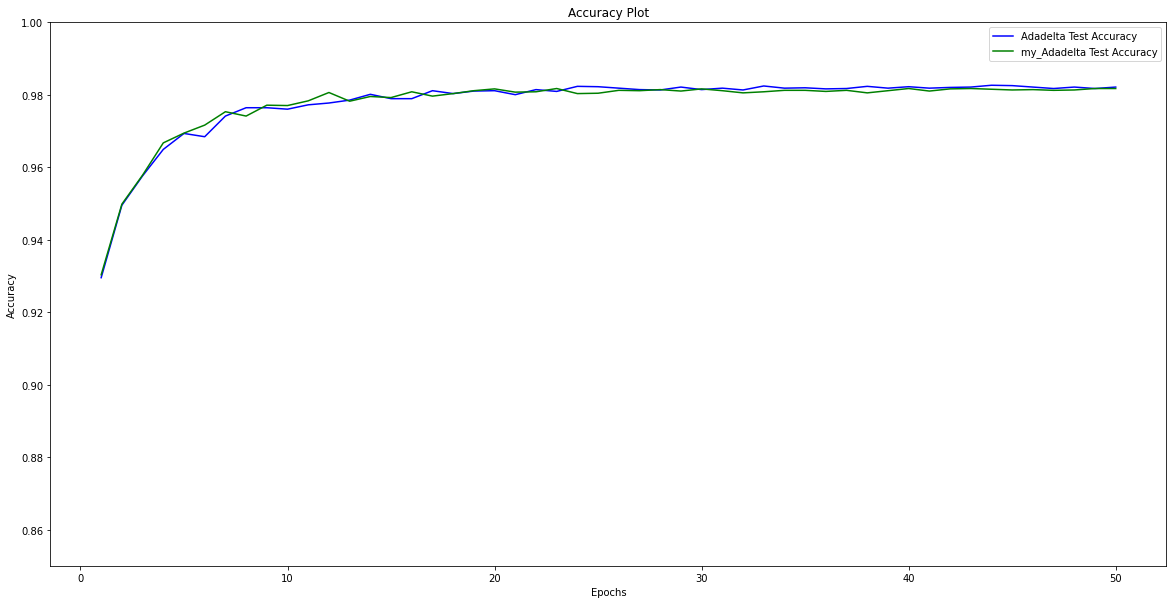

In [11]:
fig=plt.figure(figsize=(20, 10))

plt.plot(np.arange(1, no_epochs+1), adadelta_test_acc, label="Adadelta Test Accuracy", color='b')
plt.plot(np.arange(1, no_epochs+1), my_adadelta_test_acc, label="my_Adadelta Test Accuracy", color='g')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0.85, 1)
plt.title("Accuracy Plot")
plt.legend(loc='best')
plt.show()